In [ ]:
import pandas as pd
import os
from glob import glob

In [ ]:


# # File paths
# clinical_file = r"D:\mlpr data\Glioblastoma-ML-model\UPENN-GBM_clinical_info_v2.1.csv"
# radiomics_folder = r"D:\mlpr data\radiomic_features_CaPTk"

# # Load clinical data
# clinical_df = pd.read_csv(clinical_file)
# clinical_df.rename(columns={"ID": "PatientID"}, inplace=True)  # Standardizing ID column name

# # Load all radiomic CSVs and merge horizontally on PatientID
# radiomic_files = glob(os.path.join(radiomics_folder, "*.csv"))

# # Initialize empty dataframe for radiomics
# radiomics_df = pd.DataFrame()

# for file in radiomic_files:
#     df = pd.read_csv(file)
#     df.rename(columns={"SubjectID": "PatientID"}, inplace=True)  # Standardizing ID column name
    
#     # Merge radiomics files horizontally
#     if radiomics_df.empty:
#         radiomics_df = df
#     else:
#         radiomics_df = pd.merge(radiomics_df, df, on="PatientID", how="outer")

# # Merge clinical data with radiomics data
# merged_df = pd.merge(clinical_df, radiomics_df, on="PatientID", how="outer")

# # Save final merged dataset
# output_file = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
# merged_df.to_csv(output_file, index=False)

# print(f"Merged dataset saved at {output_file}")


Merged dataset saved at D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

# Load data
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert target column to numeric (forcing errors='coerce' turns non-numeric values into NaN)
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")

# Drop rows where target variable is NaN
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# Separate features (X) and target (y)
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED"])  # Drop ID and target
y = df["Survival_from_surgery_days_UPDATED"]

# Identify categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # Convert to string before encoding
    label_encoders[col] = le  # Store encoder for future use

# Fill missing numeric values with median
X = X.apply(pd.to_numeric, errors="coerce")  # Ensure all values are numeric
X = X.fillna(X.median())  # Replace NaNs with median

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

C:\Users\asp61\AppData\Local\Temp\ipykernel_31244\2365178571.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [12]:
df.shape

(644, 9516)

In [5]:

model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)  # Use all cores
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [6]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, explained_variance_score
import numpy as np

mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Root Mean Squared Error
evs = explained_variance_score(y_test, y_pred)  # Explained Variance Score

print(f"Mean Absolute Error: {mae:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Explained Variance Score: {evs:.4f}")


Mean Absolute Error: 325.74
R² Score: 0.0541
Root Mean Squared Error (RMSE): 466.49
Explained Variance Score: 0.0661


## Classifier

In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load data
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert target column to numeric (handling non-numeric values)
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")

# Drop rows where target variable is NaN
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# **Convert Survival Days into Categories (Example Binning)**
# You can modify bins as per your requirement
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [25,50, 75])  
bins = [0, percentiles[0], percentiles[1], percentiles[2], np.inf]  
labels = [0, 1, 2, 3]  # Adjust as needed
df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Separate features (X) and target (y)
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Identify categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # Convert to string before encoding
    label_encoders[col] = le  # Store encoders for future use

# Fill missing numeric values with median
X = X.apply(pd.to_numeric, errors="coerce")  # Ensure all values are numeric
X = X.fillna(X.median())  # Replace NaNs with median

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

C:\Users\asp61\AppData\Local\Temp\ipykernel_31244\2159967707.py:10: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Accuracy: 0.30
Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.39      0.43        33
           1       0.30      0.19      0.23        32
           2       0.24      0.31      0.27        32
           3       0.25      0.31      0.28        32

    accuracy                           0.30       129
   macro avg       0.32      0.30      0.30       129
weighted avg       0.32      0.30      0.30       129



In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Load data
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert target column to numeric (handling non-numeric values)
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")

# Drop rows where target variable is NaN
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [25,50, 75])  
bins = [0, percentiles[0], percentiles[1], percentiles[2], np.inf]  
labels = [0, 1, 2, 3]  # Adjust as needed
df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Separate features (X) and target (y)
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Identify categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns

# Encode categorical columns
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))  # Convert to string before encoding
    label_encoders[col] = le  # Store encoders for future use

# Fill missing numeric values with median
X = X.apply(pd.to_numeric, errors="coerce")  # Ensure all values are numeric
X = X.fillna(X.median())  # Replace NaNs with median

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply PCA
pca = PCA(n_components=0.9)  # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Train a Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

# Print the number of PCA components
print(f"Number of PCA components used: {X_pca.shape[1]}")

C:\Users\asp61\AppData\Local\Temp\ipykernel_31244\571684290.py:11: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Accuracy: 0.32
Classification Report:
               precision    recall  f1-score   support

           0       0.39      0.42      0.41        33
           1       0.31      0.25      0.28        32
           2       0.29      0.28      0.29        32
           3       0.28      0.31      0.29        32

    accuracy                           0.32       129
   macro avg       0.32      0.32      0.32       129
weighted avg       0.32      0.32      0.32       129

Number of PCA components used: 182


In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from sklearn.ensemble import StackingClassifier


# Load data
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert target column to numeric
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")

# Drop rows where target variable is NaN
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# Percentile-Based Binning
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [33, 66])
bins = [0, percentiles[0], percentiles[1], np.inf]
labels = [0, 1, 2]  

df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Separate features (X) and target (y)
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"]

# Encode categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Fill missing numeric values with median
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection using RandomForest
selector = SelectFromModel(RandomForestClassifier(n_estimators=100, random_state=42), max_features=100)
X_selected = selector.fit_transform(X_scaled, y)

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Balance Classes with SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

# Define Base Models
rf_clf = RandomForestClassifier(n_estimators=150, random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=200, learning_rate=0.05, max_depth=6, random_state=42)
log_reg = LogisticRegression(max_iter=1000)

# Voting Classifier (Soft Voting for Probabilistic Averaging)
ensemble_model_1 = VotingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg)],
    voting="soft", weights=[1.5, 1, 2.5]  # Example of weight assignment
)
stacking_clf = StackingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg)],
    final_estimator=LogisticRegression()
)
stacking_clf.fit(X_train, y_train)

# Train Ensemble Model
ensemble_model_1.fit(X_train, y_train)


# Predictions
y_pred = ensemble_model_1.predict(X_test)
y_pred_stacking = stacking_clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
accuracy_stacking = accuracy_score(y_test, y_pred_stacking)
report = classification_report(y_test, y_pred)
report_stacking = classification_report(y_test, y_pred_stacking)

print(f"Ensemble Model Accuracy: {accuracy:.2f}")
print("Classification Report:\n", report)

print(f"Stacking Model Accuracy: {accuracy_stacking:.2f}")
print("Classification Report:\n", report_stacking)


C:\Users\asp61\AppData\Local\Temp\ipykernel_27304\2524335400.py:17: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


Ensemble Model Accuracy: 0.54
Classification Report:
               precision    recall  f1-score   support

           0       0.49      0.63      0.55        43
           1       0.43      0.36      0.39        42
           2       0.72      0.64      0.67        44

    accuracy                           0.54       129
   macro avg       0.55      0.54      0.54       129
weighted avg       0.55      0.54      0.54       129

Stacking Model Accuracy: 0.56
Classification Report:
               precision    recall  f1-score   support

           0       0.53      0.70      0.60        43
           1       0.48      0.29      0.36        42
           2       0.64      0.68      0.66        44

    accuracy                           0.56       129
   macro avg       0.55      0.56      0.54       129
weighted avg       0.55      0.56      0.54       129



C:\Users\asp61\AppData\Local\Temp\ipykernel_27304\399629761.py:17: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [   2    3   69   74   80  103  104  105  107  108  110  213  218  224
  247  248  249  251  252  254  357  362  368  391  392  393  501  506
  512  535  536  537  539  540  542  645  650  656  679  680  681  683
  684  686  789  794  800  823  824  825  933  938  944  967  968  969
  971  972  974 1077 1082 1088 1111 1112 1113 1115 1116 1118 1221 1226
 1232 1255 1256 1257 1365 1370 1376 1399 1400 1401 1403 1404 1406 1509
 1514 1520 1543 1544 1545 1547 1548 1550 1653 1658 1664 1687 1688 1689
 1797 1802 1808 1831 1832 1833 1835 1836 1838 1941 1946 1952 1975 1976
 1977 1979 1980 1982 2085 2090 2096 2119 2120 2121 2229 2234 2240 2263
 2264 2265 2

Ensemble Model Accuracy: 0.50
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.70      0.62        43
           1       0.33      0.31      0.32        42
           2       0.59      0.50      0.54        44

    accuracy                           0.50       129
   macro avg       0.50      0.50      0.50       129
weighted avg       0.50      0.50      0.50       129

Stacking Model Accuracy: 0.55
Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.79      0.69        43
           1       0.33      0.21      0.26        42
           2       0.61      0.64      0.62        44

    accuracy                           0.55       129
   macro avg       0.52      0.55      0.52       129
weighted avg       0.52      0.55      0.53       129



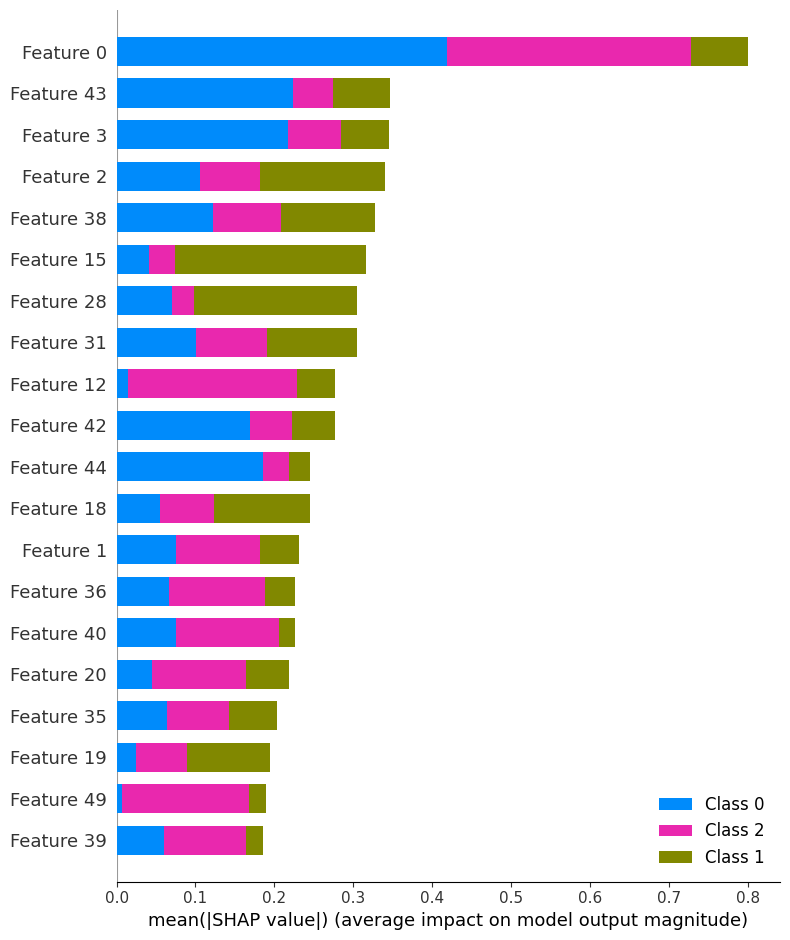

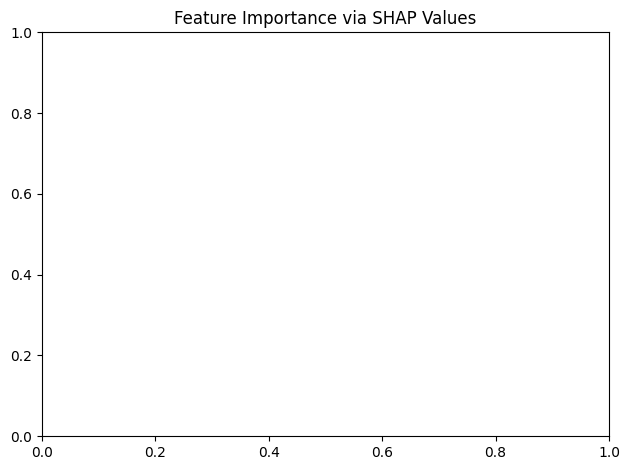

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE
import xgboost as xgb
import shap
import matplotlib.pyplot as plt

# Load data
file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
df = pd.read_csv(file_path)

# Convert target column to numeric
df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(df["Survival_from_surgery_days_UPDATED"], errors="coerce")

# Drop rows where target variable is NaN
df = df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

# Percentile-Based Binning
percentiles = np.percentile(df["Survival_from_surgery_days_UPDATED"], [33, 66])
bins = [0, percentiles[0], percentiles[1], np.inf]
labels = [0, 1, 2]  

df["Survival_Category"] = pd.cut(df["Survival_from_surgery_days_UPDATED"], bins=bins, labels=labels)

# Separate features (X) and target (y)
X = df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
y = df["Survival_Category"].astype(int)

# Encode categorical columns
categorical_cols = X.select_dtypes(include=["object"]).columns
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Fill missing numeric values with median
X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())

# Standardize numeric features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Feature Selection using SelectKBest
selector = SelectKBest(score_func=f_classif, k=50)
X_selected = selector.fit_transform(X_scaled, y)

# Train-test split (80:20)
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42, stratify=y)

# Balance Classes with BorderlineSMOTE
resampler = BorderlineSMOTE(random_state=42)
X_train, y_train = resampler.fit_resample(X_train, y_train)

# Define Base Models
rf_clf = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
xgb_clf = xgb.XGBClassifier(n_estimators=300, learning_rate=0.05, max_depth=6, random_state=42)
log_reg = LogisticRegression(C=0.5, max_iter=1000)
gb_clf = GradientBoostingClassifier(n_estimators=150, learning_rate=0.1, max_depth=4)

# Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1]
}

grid_search = GridSearchCV(xgb_clf, param_grid, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

xgb_clf = grid_search.best_estimator_

# Voting Classifier (Soft Voting)
ensemble_model_2 = VotingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg), ("GB", gb_clf)],
    voting="soft"
)

# Stacking Classifier
stacking_clf = StackingClassifier(
    estimators=[("RandomForest", rf_clf), ("XGBoost", xgb_clf), ("LogReg", log_reg)],
    final_estimator=LogisticRegression()
)

stacking_clf.fit(X_train, y_train)
ensemble_model_2.fit(X_train, y_train)

# Predictions
y_pred = ensemble_model_2.predict(X_test)
y_pred_stacking = stacking_clf.predict(X_test)

# Evaluate Models
print(f"Ensemble Model Accuracy: {accuracy_score(y_test, y_pred):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

print(f"Stacking Model Accuracy: {accuracy_score(y_test, y_pred_stacking):.2f}")
print("Classification Report:\n", classification_report(y_test, y_pred_stacking))

# Feature Importance Analysis
def analyze_feature_importance(model, X):
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X, plot_type="bar")
    plt.title("Feature Importance via SHAP Values")
    plt.tight_layout()
    plt.show()

analyze_feature_importance(xgb_clf, X_selected)


In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import xgboost as xgb

class AdvancedEnsembleClassifier:
    def __init__(self, file_path):
        # Load data
        self.df = pd.read_csv(file_path)
        self.prepare_data()
    
    def prepare_data(self):
        # Convert target column to numeric
        self.df["Survival_from_surgery_days_UPDATED"] = pd.to_numeric(
            self.df["Survival_from_surgery_days_UPDATED"], 
            errors="coerce"
        )

        # Drop rows where target variable is NaN
        self.df = self.df.dropna(subset=["Survival_from_surgery_days_UPDATED"])

        # Percentile-Based Binning with adjustment
        percentiles = np.percentile(self.df["Survival_from_surgery_days_UPDATED"], [33,66])
        bins = [0, percentiles[0], percentiles[1], np.inf]
        labels = [0, 1, 2]  

        self.df["Survival_Category"] = pd.cut(
            self.df["Survival_from_surgery_days_UPDATED"], 
            bins=bins, 
            labels=labels
        )

        # Separate features (X) and target (y)
        X = self.df.drop(columns=["PatientID", "Survival_from_surgery_days_UPDATED", "Survival_Category"])
        y = self.df["Survival_Category"].astype(int)

        # Encode categorical columns
        categorical_cols = X.select_dtypes(include=["object"]).columns
        self.label_encoders = {}

        for col in categorical_cols:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            self.label_encoders[col] = le

        # Fill missing numeric values with median
        X = X.apply(pd.to_numeric, errors="coerce").fillna(X.median())

        # Standardize numeric features
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)

        # Feature Selection
        self.selector = SelectKBest(score_func=f_classif, k=50)
        X_selected = self.selector.fit_transform(X_scaled, y)

        # Split the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X_selected, y, 
            test_size=0.2, 
            random_state=42, 
            stratify=y
        )

        # Apply SMOTE for class balancing
        smote = SMOTE(random_state=42)
        self.X_train, self.y_train = smote.fit_resample(self.X_train, self.y_train)
    
    def create_models(self):
        # Base models with improved parameters
        rf_clf = RandomForestClassifier(
            n_estimators=300, 
            max_depth=10, 
            min_samples_split=5, 
            min_samples_leaf=2, 
            random_state=42
        )
        
        xgb_clf = xgb.XGBClassifier(
            n_estimators=250, 
            learning_rate=0.05, 
            max_depth=7, 
            random_state=42
        )
        
        svm_clf = SVC(
            kernel='rbf', 
            probability=True, 
            C=1.0, 
            random_state=42
        )
        
        # Stacking Classifier with multiple base models
        stacking_clf = StackingClassifier(
            estimators=[
                ('rf', rf_clf),
                ('xgb', xgb_clf),
                ('svm', svm_clf)
            ],
            final_estimator=LogisticRegression(max_iter=1000),
            cv=5
        )
        
        return stacking_clf
    
    def train_and_evaluate(self):
        # Create and train the model
        model = self.create_models()
        model.fit(self.X_train, self.y_train)
        
        # Predictions
        y_pred = model.predict(self.X_test)
        
        # Detailed evaluation
        print("Confusion Matrix:")
        print(confusion_matrix(self.y_test, y_pred))
        
        print("\nDetailed Classification Report:")
        print(classification_report(self.y_test, y_pred))
        
        # Cross-validation
        cv_scores = cross_val_score(model, self.X_train, self.y_train, cv=5)
        print("\nCross-Validation Scores:", cv_scores)
        print("Mean CV Score:", cv_scores.mean())
        
        return model

def main():
    file_path = r"D:\mlpr data\Glioblastoma-ML-model\stackAndModel\merged_data.csv"
    ensemble = AdvancedEnsembleClassifier(file_path)
    model = ensemble.train_and_evaluate()

if __name__ == "__main__":
    main()

C:\Users\asp61\AppData\Local\Temp\ipykernel_27304\83410862.py:16: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  self.df = pd.read_csv(file_path)
c:\Users\asp61\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\feature_selection\_univariate_selection.py:111: UserWarning: Features [   2    3   69   74   80  103  104  105  107  108  110  213  218  224
  247  248  249  251  252  254  357  362  368  391  392  393  501  506
  512  535  536  537  539  540  542  645  650  656  679  680  681  683
  684  686  789  794  800  823  824  825  933  938  944  967  968  969
  971  972  974 1077 1082 1088 1111 1112 1113 1115 1116 1118 1221 1226
 1232 1255 1256 1257 1365 1370 1376 1399 1400 1401 1403 1404 1406 1509
 1514 1520 1543 1544 1545 1547 1548 1550 1653 1658 1664 1687 1688 1689
 1797 1802 1808 1831 1832 1833 1835 1836 1838 1941 1946 1952 1975 1976
 1977 1979 1980 1982 2085 2090 2096 2119 2120 2121 2229 2234 2240 2263
 2264 22

Confusion Matrix:
[[33  5  5]
 [17  7 18]
 [ 5 10 29]]

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.77      0.67        43
           1       0.32      0.17      0.22        42
           2       0.56      0.66      0.60        44

    accuracy                           0.53       129
   macro avg       0.49      0.53      0.50       129
weighted avg       0.49      0.53      0.50       129


Cross-Validation Scores: [0.47619048 0.4952381  0.47619048 0.52380952 0.52380952]
Mean CV Score: 0.4990476190476191
